# Time complexity

In [5]:
import os
import sys
import time
import gc
import psutil
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
#sns.set_style("dark")

sys.path.extend([os.getcwd() + "/../", os.getcwd() + "/../../bin/", os.getcwd() + "/../../tests/python/module", os.getcwd() + "/../../tests/python/"])
import state_space_model
from benchmark_performance import *

current_memory = lambda: psutil.Process(os.getpid()).memory_info().rss
current_time = lambda: time.time()

plt.rcParams["figure.figsize"] = (7.5, 5)

In [6]:

def test_algorithm(method, obs_dim, lat_dim, T):
    Y = np.random.randn(obs_dim, T)
    t0 = current_time()
    m0 = current_memory()
    ssm.estimate(
            method, "F H Q R X0 P0", Y,
            obs_dim, lat_dim, T,
            F=None, H=None, 
            Q=None, R=None, 
            X0=None, P0=None, 
            min_iterations=1,
            max_iterations=1, 
            min_improvement=0.01,
            sample_size=3000,
            population_size=100,
            penalty_low_variance_Q=0.1,
            penalty_low_variance_R=0.1,
            penalty_low_variance_P0=0.1,
            penalty_low_std_mean_ratio=0.1,
            penalty_inestable_system=10.0,
            penalty_mse=100,#1e-1,
            penalty_roughness_X=0.1,#0.5,
            penalty_roughness_Y=0.1,#0.5,
            max_length_loglikelihood=1000,
            return_details=True
    )
    return (current_time() - t0, current_memory() - m0)

def test_params(method="PSO", obs_dim_range=[1, 5, 10, 15, 20], lat_dim_range=[1, 5, 10, 15, 20], T_range=[50, 100, 200]):
    data = []
    for obs_dim in obs_dim_range:
        print("+", obs_dim)
        for lat_dim in [v for v in lat_dim_range if v <= obs_dim]:
            print("+---", lat_dim, end=": ")
            for T in T_range:
                print(T, end=" ")
                t, m = test_algorithm(method, obs_dim, lat_dim, T)
                data.append([obs_dim, lat_dim, T, t, m])
            print()
    data = np.array(data)
    #for k, (obs_dim, lat_dim, T, _, _) in enumerate(data):
    #    data[k, 3: ] = test_algorithm(method, obs_dim, lat_dim, T)
    return data

def lse(X, Y, Xs=None, p=1):
    Xs = Xs if Xs is not None else X.copy() 
    X = X.reshape(-1, 1)
    for k in range(2, p + 1):
        X = np.insert(X, 0, values=X[:, -1] ** k, axis=1)
    X = np.insert(X, 0, values=1, axis=1)
    Xs = Xs.reshape(-1, 1)
    for k in range(2, p + 1):
        Xs = np.insert(Xs, 0, values=Xs[:, -1] ** k, axis=1)
    Xs = np.insert(Xs, 0, values=1, axis=1)
    Y = Y.reshape(-1, 1)
    beta = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(Y)
    print("Beta: ", beta.ravel())
    return Xs.dot(beta).ravel()


# I. PSO

In [7]:
method = "PSO"
A = [1, 5, 10, 20, 30]
B = [1, 5, 10, 20, 30]
C = [10, 20, 50, 100, 500]
#C = [10, 20, 50]
fname = "speed_mem_results_pso.db"
if os.path.exists(fname):
    with open(fname, "rb") as f:
        R = pickle.load(f)
else:
    R = test_params(method, obs_dim_range=A, lat_dim_range=B, T_range=C).T
    with open(fname, "wb") as f:
        pickle.dump(R, f)

A1, B1, C1, T1, M1 = R
A1, B1, C1, T1, M1 = [v.reshape(-1, 1) for v in (A1, B1, C1, T1, M1)]
norm = lambda A1: (A1 - A1.mean()) / A1.std()
#A1, B1, C1 = norm(A1), norm(B1), norm(C1)

names = [
    "o^3", "l^3", "T^3", 
    "o^2", "o",
    "l^2", "l",
    "T^2", "T",
    "o^2 l", "o l",
    "o^2 T", "o T",
    "l^2 o",
    "l^2 T", "l T",
    "T^2 o",
    "T^2 l",
]
Z = np.hstack((
    A1 ** 3, B1 ** 3, C1 ** 3, 
    A1 ** 2, A1, 
    B1 ** 2, B1, 
    C1 ** 2, C1, 
    A1 ** 2 * B1, A1 * B1, 
    A1 ** 2 * C1, A1 * C1, 
    B1 ** 2 * A1,
    B1 ** 2 * C1, B1 * C1, 
    C1 ** 2 * A1,
    C1 ** 2 * B1,
    np.ones(A1.shape)
)).astype("f8")
beta = np.linalg.inv(Z.T.dot(Z)).dot(Z.T).dot(T1)
var_beta = np.sum((T1 - Z.dot(beta)) ** 2) / (T1.shape[0] - Z.shape[1]) * np.linalg.inv(Z.T.dot(Z))
print("Regression coefficients:")
print("\n".join([
    "{0}: {1:.2g} +/- {2:.2g}".format(n, b, e)
    for n, b, e in sorted(zip(names, beta.ravel(), np.diag(var_beta).ravel()), key=lambda r: np.abs(r[1]), reverse=True)
    if np.abs(b) - e > 0.01
]))


Regression coefficients:
o: 1.1 +/- 0.72
o l: 0.12 +/- 0.015
o^2: -0.11 +/- 0.0043
l^2: -0.036 +/- 0.0072
T: 0.024 +/- 0.013


In [8]:
names = [
    #"o^3", "l^3", "T^3", 
    "o^2", "o",
    "l^2", "l",
    "T^2", "T",
    "o^2 l", "o l",
    "o^2 T", "o T",
    "l^2 o",
    "l^2 T", "l T",
    "T^2 o",
    "T^2 l",
]
Z = np.hstack((
    #A1 ** 3, B1 ** 3, C1 ** 3, 
    A1 ** 2, A1, 
    B1 ** 2, B1, 
    C1 ** 2, C1, 
    A1 ** 2 * B1, A1 * B1, 
    A1 ** 2 * C1, A1 * C1, 
    B1 ** 2 * A1,
    B1 ** 2 * C1, B1 * C1, 
    C1 ** 2 * A1,
    C1 ** 2 * B1,
    np.ones(A1.shape)
)).astype("f8")
beta = np.linalg.inv(Z.T.dot(Z)).dot(Z.T).dot(T1)
var_beta = np.sum((T1 - Z.dot(beta)) ** 2) / (T1.shape[0] - Z.shape[1]) * np.linalg.inv(Z.T.dot(Z))
print("Regression coefficients:")
print("\n".join([
    "{0}: {1:.2g} +/- {2:.2g}".format(n, b, e)
    for n, b, e in sorted(zip(names, beta.ravel(), np.diag(var_beta).ravel()), key=lambda r: np.abs(r[1]), reverse=True)
    if np.abs(b) - e > 0.01
]))


Regression coefficients:
l: 0.8 +/- 0.62
o l: -0.047 +/- 0.0091
T: 0.038 +/- 0.0025
o^2: 0.013 +/- 0.00022


Therefore, it can be seen that the complexity is
$$
O\left(
    o ^ 2 + l ^ 2 + T
\right)
$$

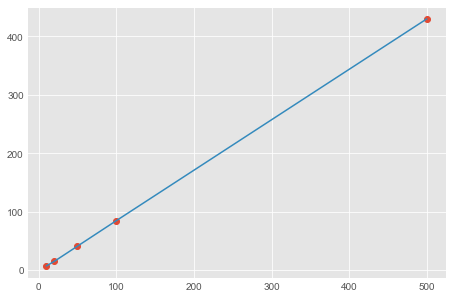

In [9]:
plt.rcParams["figure.figsize"] = (7.5, 5)
cond  = np.where((A1 == 30) * (B1 == 30))
A2, B2, C2, T2 = A1[cond], B1[cond], C1[cond], T1[cond]
plt.plot(C2, T2, "o")
plt.plot(C2, T2, "-")

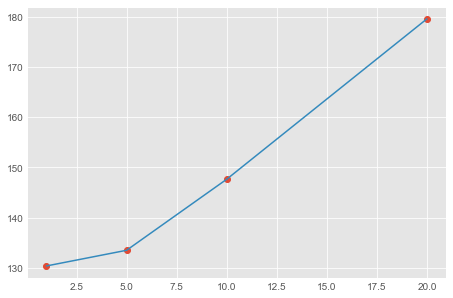

In [10]:
plt.rcParams["figure.figsize"] = (7.5, 5)
cond  = np.where((A1 == 20) * (C1 ==500))
A2, B2, C2, T2 = A1[cond], B1[cond], C1[cond], T1[cond]
plt.plot(B2, T2, "o")
plt.plot(B2, T2, "-")

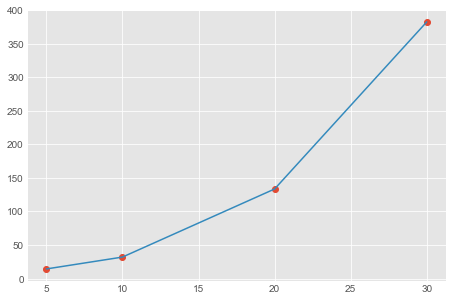

In [11]:
plt.rcParams["figure.figsize"] = (7.5, 5)
cond  = np.where((B1 == 5) * (C1 == 500))
A2, B2, C2, T2 = A1[cond], B1[cond], C1[cond], T1[cond]
plt.plot(A2, T2, "o")
plt.plot(A2, T2, "-")

# II. EM

In [12]:
method = "EM"
A = [1, 5, 10, 20, 30]
B = [1, 5, 10, 20, 30]
C = [10, 20, 50, 100, 500]
#C = [10, 20, 50]
fname = "speed_mem_results_em.db"
if os.path.exists(fname):
    with open(fname, "rb") as f:
        R = pickle.load(f)
else:
    R = test_params(method, obs_dim_range=A, lat_dim_range=B, T_range=C).T
    with open(fname, "wb") as f:
        pickle.dump(R, f)

A1, B1, C1, T1, M1 = R
A1, B1, C1, T1, M1 = [v.reshape(-1, 1) for v in (A1, B1, C1, T1, M1)]
norm = lambda A1: (A1 - A1.mean()) / A1.std()
#A1, B1, C1 = norm(A1), norm(B1), norm(C1)

names = [
    "o^3", "l^3", "T^3", 
    "o^2", "o",
    "l^2", "l",
    "T^2", "T",
    "o^2 l", "o l",
    "o^2 T", "o T",
    "l^2 o",
    "l^2 T", "l T",
    "T^2 o",
    "T^2 l",
]
Z = np.hstack((
    A1 ** 3, B1 ** 3, C1 ** 3, 
    A1 ** 2, A1, 
    B1 ** 2, B1, 
    C1 ** 2, C1, 
    A1 ** 2 * B1, A1 * B1, 
    A1 ** 2 * C1, A1 * C1, 
    B1 ** 2 * A1,
    B1 ** 2 * C1, B1 * C1, 
    C1 ** 2 * A1,
    C1 ** 2 * B1,
    np.ones(A1.shape)
)).astype("f8")
beta = np.linalg.inv(Z.T.dot(Z)).dot(Z.T).dot(T1)
var_beta = np.sum((T1 - Z.dot(beta)) ** 2) / (T1.shape[0] - Z.shape[1]) * np.linalg.inv(Z.T.dot(Z))
print("Regression coefficients:")
print("\n".join([
    "{0}: {1:.2g} +/- {2:.2g}".format(n, b, e)
    for n, b, e in sorted(zip(names, beta.ravel(), np.diag(var_beta).ravel()), key=lambda r: np.abs(r[1]), reverse=True)
    if np.abs(b) - e > 0.001
]))


Regression coefficients:
l: 0.013 +/- 0.00013
o: -0.0047 +/- 0.00011
o l: -0.0018 +/- 2.4e-06
T: -0.0018 +/- 2e-06


Therefore, it can be seen that the complexity is
$$
O\left(
    o + l + T
\right)
$$

# III. LSE+PSO

In [13]:
method = "LSE+PSO"
A = [1, 5, 10, 20, 30]
B = [1, 5, 10, 20, 30]
C = [10, 20, 50, 100, 500]
#C = [10, 20, 50]
fname = "speed_mem_results_lse_pso.db"
if os.path.exists(fname):
    with open(fname, "rb") as f:
        R = pickle.load(f)
else:
    R = test_params(method, obs_dim_range=A, lat_dim_range=B, T_range=C).T
    with open(fname, "wb") as f:
        pickle.dump(R, f)

A1, B1, C1, T1, M1 = R
A1, B1, C1, T1, M1 = [v.reshape(-1, 1) for v in (A1, B1, C1, T1, M1)]
norm = lambda A1: (A1 - A1.mean()) / A1.std()
#A1, B1, C1 = norm(A1), norm(B1), norm(C1)

names = [
    #"o^3", "l^3", "T^3", 
    "o^2", "o",
    "l^2", "l",
    "T^2", "T",
    "o^2 l", "o l",
    "o^2 T", "o T",
    "l^2 o",
    "l^2 T", "l T",
    "T^2 o",
    "T^2 l",
]
Z = np.hstack((
    #A1 ** 3, B1 ** 3, C1 ** 3, 
    A1 ** 2, A1, 
    B1 ** 2, B1, 
    C1 ** 2, C1, 
    A1 ** 2 * B1, A1 * B1, 
    A1 ** 2 * C1, A1 * C1, 
    B1 ** 2 * A1,
    B1 ** 2 * C1, B1 * C1, 
    C1 ** 2 * A1,
    C1 ** 2 * B1,
    np.ones(A1.shape)
)).astype("f8")
beta = np.linalg.inv(Z.T.dot(Z)).dot(Z.T).dot(T1)
var_beta = np.sum((T1 - Z.dot(beta)) ** 2) / (T1.shape[0] - Z.shape[1]) * np.linalg.inv(Z.T.dot(Z))
print("Regression coefficients:")
print("\n".join([
    "{0}: {1:.2g} +/- {2:.2g}".format(n, b, e)
    for n, b, e in sorted(zip(names, beta.ravel(), np.diag(var_beta).ravel()), key=lambda r: np.abs(r[1]), reverse=True)
    if np.abs(b) - e > 0.01
]))


Regression coefficients:
l^2: 0.48 +/- 0.037
o l: -0.28 +/- 0.049
l T: 0.025 +/- 6.8e-05
o^2: -0.02 +/- 0.0012
o T: -0.018 +/- 5.2e-05
l^2 o: -0.015 +/- 4.4e-05
o^2 l: 0.011 +/- 4.9e-05


Therefore, it can be seen that the complexity is
$$
O\left(
    o ^ 2 + l ^ 2 + T
\right)
$$

# IV. EM+PSO

In [14]:
method = "EM+PSO"
A = [1, 5, 10, 20, 30]
B = [1, 5, 10, 20, 30]
C = [10, 20, 50, 100, 500]
#C = [10, 20, 50]
fname = "speed_mem_results_em_pso.db"
if os.path.exists(fname):
    with open(fname, "rb") as f:
        R = pickle.load(f)
else:
    R = test_params(method, obs_dim_range=A, lat_dim_range=B, T_range=C).T
    with open(fname, "wb") as f:
        pickle.dump(R, f)

A1, B1, C1, T1, M1 = R
A1, B1, C1, T1, M1 = [v.reshape(-1, 1) for v in (A1, B1, C1, T1, M1)]
norm = lambda A1: (A1 - A1.mean()) / A1.std()
#A1, B1, C1 = norm(A1), norm(B1), norm(C1)

names = [
    "o^3", "l^3", "T^3", 
    "o^2", "o",
    "l^2", "l",
    "T^2", "T",
    "o^2 l", "o l",
    "o^2 T", "o T",
    "l^2 o",
    "l^2 T", "l T",
    "T^2 o",
    "T^2 l",
]
Z = np.hstack((
    A1 ** 3, B1 ** 3, C1 ** 3, 
    A1 ** 2, A1, 
    B1 ** 2, B1, 
    C1 ** 2, C1, 
    A1 ** 2 * B1, A1 * B1, 
    A1 ** 2 * C1, A1 * C1, 
    B1 ** 2 * A1,
    B1 ** 2 * C1, B1 * C1, 
    C1 ** 2 * A1,
    C1 ** 2 * B1,
    np.ones(A1.shape)
)).astype("f8")
beta = np.linalg.inv(Z.T.dot(Z)).dot(Z.T).dot(T1)
var_beta = np.sum((T1 - Z.dot(beta)) ** 2) / (T1.shape[0] - Z.shape[1]) * np.linalg.inv(Z.T.dot(Z))
print("Regression coefficients:")
print("\n".join([
    "{0}: {1:.2g} +/- {2:.2g}".format(n, b, e)
    for n, b, e in sorted(zip(names, beta.ravel(), np.diag(var_beta).ravel()), key=lambda r: np.abs(r[1]), reverse=True)
    if np.abs(b) - e > 0.01
]))


Regression coefficients:
o: -0.59 +/- 0.062
l: -0.2 +/- 0.074
o^2: 0.046 +/- 0.00038
l^2: 0.038 +/- 0.00062
o l: -0.012 +/- 0.0013


Therefore, it can be seen that the complexity is
$$
O\left(
    o ^ 2 + l ^ 2 + T
\right)
$$